VAE viewer notebook for DonkeyCar
===

This notebook can visualize vae. This repository using JetBot real camera.

In [0]:
import sys
import PIL
import numpy as np
import cv2
import traitlets
import ipywidgets.widgets as widgets
from IPython.display import display
import torch
from torchvision.transforms import transforms
#sys.path.append('../../../vae')
#from vae import VAE
#from jetcam.csi_camera import CSICamera
#from jetcam.utils import bgr8_to_jpeg

In [0]:
%cd /content/
!mkdir data
%cd /content/data
!rm -r * #Erase in case of old data 
!git clone https://github.com/doc-beha/donkey_car_training_data_sim # get the latest data
!mv /content/data/donkey_car_training_data_sim/* /content/data/    #
!rm -r donkey_car_training_data_sim

/content
/content/data
rm: cannot remove '*': No such file or directory
Cloning into 'donkey_car_training_data_sim'...
remote: Enumerating objects: 13933, done.
remote: Counting objects: 100% (13933/13933), done.
remote: Compressing objects: 100% (4967/4967), done.
remote: Total 13933 (delta 9148), reused 13745 (delta 8963), pack-reused 0
Receiving objects: 100% (13933/13933), 12.56 MiB | 7.68 MiB/s, done.
Resolving deltas: 100% (9148/9148), done.


In [0]:
%cd /content/
!mkdir vae
%cd /content/vae
!rm -r * #Erase in case of old data 
!git clone  https://github.com/doc-beha/donkey_car_models_simulator.git # get the latest data
!mv /content/vae/donkey_car_models_simulator/* /content/data/vae/    #
!rm -r donkey_car_models_simulator

/content
/content/vae
rm: cannot remove '*': No such file or directory
Cloning into 'donkey_car_models_simulator'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 35 (delta 8), reused 29 (delta 2), pack-reused 0
Unpacking objects: 100% (35/35), done.


## Setting Parameter

|Name | Description| Default|
|:----|:-----------|:-------|
|IMAGE_CHANNELS | Image channel such as RGB | 3 Not change|
|VARIANTS_SIZE  | Variants size of VAE      | 32          |
|MODEL_PATH     | Trained VAE model file path | ../../vae.torch|

In [0]:
IMAGE_CHANNELS = 3
VARIANTS_SIZE = 32
MODEL_PATH = '/content/data/vae/vae_tub_1_20-05-25_try2.torch'

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=256):
        return input.view(input.size(0), size, 3, 8)


class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=6144, z_dim=32):
        super(VAE, self).__init__()
        self.z_dim = z_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=4, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), F.softplus(self.fc2(h))
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

    def loss_fn(self, images, reconst, mean, logvar):
        KL = -0.5 * torch.sum((1 + logvar - mean.pow(2) - logvar.exp()), dim=0)
        KL = torch.mean(KL)
        reconstruction = F.binary_cross_entropy(reconst.view(-1,38400), images.view(-1, 38400), reduction='sum') #size_average=False)
        return reconstruction + 5.0 * KL

## Load trained VAE model.
Loading trained VAE model on GPU memory. 

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae = VAE(image_channels=IMAGE_CHANNELS, z_dim=VARIANTS_SIZE)
vae.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device(device)))
vae.to(device).eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (7): ReLU()
    (8): Flatten()
  )
  (fc1): Linear(in_features=6144, out_features=32, bias=True)
  (fc2): Linear(in_features=6144, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=6144, bias=True)
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2))
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2))
    (6): ReLU()
    (7): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2))
    (8): Sigmoid()
  )
)

## Define preprocess and postprocess

In [0]:
def preprocess(image):
    observe = PIL.Image.fromarray(image)
    observe = observe.resize((160,120))
    croped = observe.crop((0, 40, 160, 120))
    tensor = transforms.ToTensor()(croped)
    return tensor
    

def rgb8_to_jpeg(image):
    return bytes(cv2.imencode('.jpg', image)[1])

## Visualize latent space function

In [0]:
ABS_LATENT_MAX_VALUE = 10
PANEL_HEIGHT = 10
PANEL_WIDTH = 10

def sigmoid(x, gain=1, offset_x=0):
    return ((np.tanh(((x+offset_x)*gain)/2)+1)/2)

def color_bar_rgb(x):
    gain = 10
    offset_x= 0.2
    offset_green = 0.6
    x = (x * 2) - 1
    red = sigmoid(x, gain, -1*offset_x)
    blue = 1-sigmoid(x, gain, offset_x)
    green = sigmoid(x, gain, offset_green) + (1-sigmoid(x,gain,-1*offset_green))
    green = green - 1.0
    return [blue * 255,green * 255,red * 255]

def _get_color(value):
    t = (value + ABS_LATENT_MAX_VALUE) / (ABS_LATENT_MAX_VALUE * 2.0)
    color = color_bar_rgb(t)
    return color

def create_color_panel(latent_spaces):
    images = []
    for z in latent_spaces:
        p = np.zeros((PANEL_HEIGHT, PANEL_WIDTH, 3))
        color = _get_color(z)
        p += color[::-1]
        p = np.clip(p, 0, 255)
        images.append(p)
    panel = np.concatenate(images, axis=1)
    return panel

## Start main process

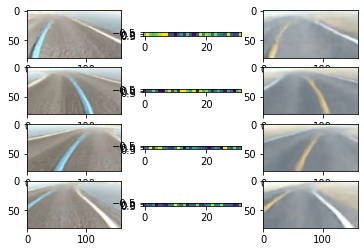

In [0]:
from PIL import Image
import io
import matplotlib.pyplot as plt

def image_to_byte_array(image:Image):
  imgByteArr = io.BytesIO()
  image.save(imgByteArr, format=image.format)
  imgByteArr = imgByteArr.getvalue()
  return imgByteArr

def vae_process(change):
    image = change['new']
    image = preprocess(image)
    resize_value = rgb8_to_jpeg(np.transpose(np.uint8(image*255),[1,2,0]))
    z, _ ,_ = vae.encode(torch.stack((image,image),dim=0)[:-1].to(device))
    reconst = vae.decode(z)
    #return reconst

    reconst = reconst.detach().cpu()[0].numpy()
    reconst = np.transpose(np.uint8(reconst*255),[1,2,0])

    return reconst, z
    result_value = rgb8_to_jpeg(reconst)
    #return result_value
    latent_space = z.detach().cpu().numpy()[0]
    return rgb8_to_jpeg(create_color_panel(latent_space))

from PIL import Image
from io import BytesIO
import cv2

# name of training-data-set
tub_name="tub_1_20-05-25"
data_path = "/content/data/"
num_images = 4
i = 0

f, axarr = plt.subplots(num_images,3)

import glob,os
files = glob.glob(os.path.join(data_path, tub_name, '*.jpg'))
for f in files:

  orig_image = cv2.imread(f)
  reconst, z = vae_process({'new': orig_image})

  import torch
  import torchvision.transforms.functional as F_
  reconst_image = F_.to_pil_image(reconst)
  z = F_.to_pil_image(z)

  import matplotlib.pyplot as plt
  orig_image = PIL.Image.fromarray(orig_image)
  orig_image = orig_image.resize((160,120))
  orig_image = orig_image.crop((0, 40, 160, 120))

  axarr[i,0].imshow(orig_image)
  axarr[i,1].imshow(z)
  axarr[i,2].imshow(reconst_image)

  i = i + 1

  if i >= num_images:
    break

